In [1]:
#Loading modules

import deepchem as dc
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import Features
from rdkit.Chem import Fragments as fr
from rdkit.Chem import rdMolDescriptors
import tensorflow as tf

import pandas as pd

from matplotlib import pyplot as plt

import numpy as np

from sklearn import metrics
from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings("ignore")

In [2]:
import model_stats

In [32]:
tasks, datasets, transformers = dc.molnet.load_tox21(featurizer='ECFP', splitter='random', reload=False)
train_dataset, valid_dataset, test_dataset = datasets
print(train_dataset)

[10:08:10] WARNING: not removing hydrogen atom without neighbors


<DiskDataset X.shape: (6264, 1024), y.shape: (6264, 12), w.shape: (6264, 12), task_names: ['NR-AR' 'NR-AR-LBD' 'NR-AhR' ... 'SR-HSE' 'SR-MMP' 'SR-p53']>


In [41]:
train_df = train_dataset.to_dataframe()
test_df = test_dataset.to_dataframe()
valid_df = valid_dataset.to_dataframe()

In [42]:
X_train = train_df.filter(like='X', axis=1)
X_test = test_df.filter(like='X', axis=1)
X_valid = valid_df.filter(like='X', axis=1)


In [54]:
y_train_df = train_df[['y1', 'y2', 'y3', 'y4', 'y5', 'y6', 'y7']]
y_test_df = test_df[['y1', 'y2', 'y3', 'y4', 'y5', 'y6', 'y7']]
y_valid_df = valid_df[['y1', 'y2', 'y3', 'y4', 'y5', 'y6', 'y7']]

In [55]:
y_train_df = np.where(y_train_df.sum(axis=1) > 0, 1, 0)
y_test_df = np.where(y_test_df.sum(axis=1) > 0, 1, 0)
y_valid_df = np.where(y_valid_df.sum(axis=1) > 0, 1, 0)


In [59]:
train = X_train
train['tox'] = y_train_df

test = X_test
test['tox'] = y_test_df

valid = X_valid
valid['tox'] = y_valid_df

In [95]:
y_test = y_test_df
y_valid = y_valid_df

len(y_test)

784

In [96]:
len(X_test)

784

In [61]:
from sklearn.utils import resample

percent_toxic = 100*sum(train['tox'])/len(train)
percent_non_toxic = 100 - percent_toxic

df_majority = train[train['tox']==0]
df_minority = train[train['tox']==1]



In [62]:
print(len(df_majority), len(df_minority))

4757 1507


In [63]:
df_minority_oversampled = resample(df_minority, 
                                 replace=True, 
                                 n_samples= len(df_majority))

df_oversampled = pd.concat([df_majority, df_minority_oversampled])

df_oversampled

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X1016,X1017,X1018,X1019,X1020,X1021,X1022,X1023,X1024,tox
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3742,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
294,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
5975,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1


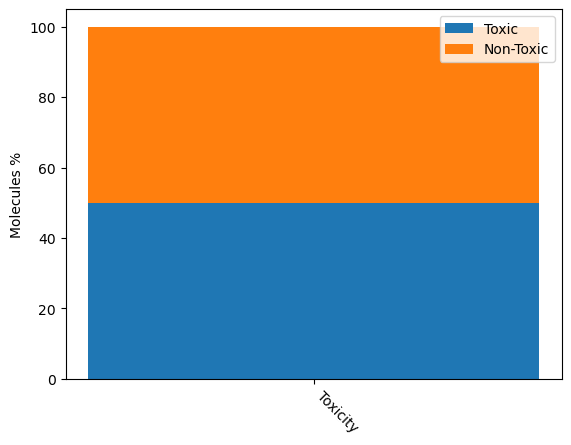

In [65]:
from matplotlib import pyplot as plt

percent_toxic = 100*sum(df_oversampled['tox'])/len(df_oversampled)
percent_non_toxic = 100-percent_toxic

ax=plt.bar('Toxicity',percent_toxic, label='Toxic')
plt.bar('Toxicity',percent_non_toxic, bottom= percent_toxic, label='Non-Toxic')
plt.xticks(rotation=-45, ha='left')
plt.ylabel("Molecules %")
plt.legend()

In [67]:
X_train = df_oversampled.drop(['tox'], axis = 1)

y_train = df_oversampled[['tox']]

In [97]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(criterion='gini',   # gini criteron measures the probability of misclassification for each split - values close to zero are ideal.
                             max_depth = 10,     # maximum depth of each decision tree
                             min_samples_split = 20,  # minimum number of samples required to split an internal node
                             random_state = 5)

In [98]:
rf_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_split=20, random_state=5)

In [99]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier()

In [100]:
sgd_clf.fit(X_train, y_train)

SGDClassifier()

In [101]:
from sklearn.svm import SVC

svm_clf = SVC()

In [102]:
svm_clf.fit(X_train, y_train)

SVC()

In [103]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()


In [104]:
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [105]:
from sklearn.naive_bayes import GaussianNB

nb_clf = GaussianNB()

In [106]:
nb_clf.fit(X_train, y_train)

GaussianNB()

In [125]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier


clf1 = LogisticRegression()
clf2 = DecisionTreeClassifier()
clf3 = nb_clf
clf4 = knn
clf5 = svm_clf
clf6 = rf_clf

ensemble = VotingClassifier(
    estimators=[('lr', clf1), 
                ('dt', clf2), 
                ('nb', clf3), 
                ('knn', clf4), 
                ('svc', clf5), 
                ('rf', clf6)], voting='soft')



TypeError: __init__() got an unexpected keyword argument 'probability'

In [124]:
ensemble.fit(X_train, y_train)

TypeError: fit() got an unexpected keyword argument 'probability'

In [109]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(1000,300, 50), max_iter=400, activation='relu', solver='adam')


In [110]:
mlp.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(1000, 300, 50), max_iter=400)

In [111]:
tf_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(750, activation='relu'), # Create a fully connected dense layer with dense1 number of neurons
    tf.keras.layers.BatchNormalization(), # Batch normalisation reduces variability of our model
    tf.keras.layers.Dropout(rate=0.8), # Dropout will reduce overtraining
    tf.keras.layers.Dense(150, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(rate=0.8),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.Dense(1, activation='sigmoid') # output layer
])

tf_model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

In [112]:
tf_model.fit(X_train, y_train, validation_data=(X_train, y_train), epochs=500)

Epoch 1/500
298/298 [==============================] - 8s 17ms/step - loss: 0.8385 - accuracy: 0.5120 - val_loss: 0.6936 - val_accuracy: 0.5036
Epoch 2/500
298/298 [==============================] - 5s 15ms/step - loss: 0.7167 - accuracy: 0.5377 - val_loss: 0.6801 - val_accuracy: 0.5316
Epoch 3/500
298/298 [==============================] - 5s 15ms/step - loss: 0.6930 - accuracy: 0.5494 - val_loss: 0.6762 - val_accuracy: 0.5429
Epoch 4/500
298/298 [==============================] - 5s 15ms/step - loss: 0.6843 - accuracy: 0.5575 - val_loss: 0.6827 - val_accuracy: 0.5289
Epoch 5/500
298/298 [==============================] - 5s 16ms/step - loss: 0.6783 - accuracy: 0.5661 - val_loss: 0.6774 - val_accuracy: 0.5379
Epoch 6/500
298/298 [==============================] - 4s 14ms/step - loss: 0.6760 - accuracy: 0.5708 - val_loss: 0.6742 - val_accuracy: 0.5399
Epoch 7/500
298/298 [==============================] - 4s 14ms/step - loss: 0.6731 - accuracy: 0.5783 - val_loss: 0.6640 - val_accuracy:

KeyboardInterrupt: 

In [126]:
models = {
    'Random Forest': rf_clf,
    'SGD': sgd_clf,
    'SVM': svm_clf,
    'KNN': knn,
    'Naive Bayes': nb_clf,
    #'Ensemble': ensemble,
    'MLP': mlp,
    'Tensorflow': tf_model
}

In [128]:
y_test

array([1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,

In [129]:
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


for key, model in models.items():
    y_pred = model.predict(X_test)
    
    y_pred = np.where(y_pred >= 0.5, 1, 0)

    f1_scores = f1_score(y_test, y_pred)
    f2_score = fbeta_score(y_test, y_pred, beta=2)
    accuracy = accuracy_score(y_test, y_pred)

    cm = confusion_matrix(y_test, y_pred)

    print(f'{key} _____________________________________________ \n {cm} \n {f1_scores} \n {f2_score} \n {accuracy}')

Random Forest _____________________________________________ 
 [[442 133]
 [ 84 125]] 
 0.5353319057815845 
 0.5712979890310786 
 0.7232142857142857
SGD _____________________________________________ 
 [[440 135]
 [ 98 111]] 
 0.48791208791208796 
 0.5129390018484289 
 0.7028061224489796
SVM _____________________________________________ 
 [[509  66]
 [114  95]] 
 0.5135135135135135 
 0.4764292878635908 
 0.7704081632653061
KNN _____________________________________________ 
 [[443 132]
 [ 88 121]] 
 0.5238095238095238 
 0.5555555555555556 
 0.7193877551020408
Naive Bayes _____________________________________________ 
 [[439 136]
 [107 102]] 
 0.4563758389261745 
 0.4748603351955308 
 0.6900510204081632
MLP _____________________________________________ 
 [[500  75]
 [125  84]] 
 0.45652173913043476 
 0.42211055276381915 
 0.7448979591836735
25/25 [==============================] - 1s 7ms/step
Tensorflow _____________________________________________ 
 [[519  56]
 [123  86]] 
 0.490028490028